In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
data_folder = "data/"
filename = "customBenchmark_kepler_query_TwoNodes.json"

In [3]:
file = open(data_folder + filename)
data = file.read()
data = json.loads(data)

In [4]:
data.keys()

dict_keys(['kepler_container_bpf_block_irq_total', 'kepler_container_bpf_cpu_time_us_total', 'kepler_container_bpf_net_rx_irq_total', 'kepler_container_bpf_net_tx_irq_total', 'kepler_container_bpf_page_cache_hit_total', 'kepler_container_cache_miss_total', 'kepler_container_core_joules_total', 'kepler_container_cpu_cycles_total', 'kepler_container_cpu_instructions_total', 'kepler_container_dram_joules_total', 'kepler_container_joules_total', 'kepler_container_other_joules_total', 'kepler_container_package_joules_total', 'kepler_container_uncore_joules_total', 'kepler_exporter_build_info', 'kepler_node_core_joules_total', 'kepler_node_dram_joules_total', 'kepler_node_info', 'kepler_node_other_joules_total', 'kepler_node_package_joules_total', 'kepler_node_platform_joules_total', 'kepler_node_uncore_joules_total', 'node_cpu_seconds_total'])

In [5]:
result = {}

for metric in data:
    temp = []
    if metric == 'node_cpu_seconds_total':
        for node_metric in data[metric]:
            if node_metric['metric']['mode'] == "idle":
                continue
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['cpu'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    elif metric == 'kepler_node_core_joules_total':
        for node_metric in data[metric]:
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['package'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    elif metric == 'kepler_node_dram_joules_total':
        for node_metric in data[metric]:
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['package'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    elif metric == 'kepler_node_package_joules_total':
        for node_metric in data[metric]:
            tmp = [[node_metric['metric']['instance'], node_metric['metric']['package'], values[0], values[1]] for values in node_metric['values']]
            tmp_df = pd.DataFrame(tmp, columns =['node', 'cpu', 'time', 'value'])
            temp.append(tmp_df)
    else:
        continue
    t = pd.concat(temp)
    t['value'] = t['value'].astype(float)
    result[metric] = t.reset_index(drop = True)

In [6]:
# result['node_cpu_seconds_total']
result.keys()

dict_keys(['kepler_node_core_joules_total', 'kepler_node_dram_joules_total', 'kepler_node_package_joules_total', 'node_cpu_seconds_total'])

In [7]:
cpu_util = result['node_cpu_seconds_total']
cpu_util_agg = cpu_util.groupby(['node', 'time'], as_index=False)['value'].sum()
node_core_power = result['kepler_node_core_joules_total']
node_core_power = node_core_power.groupby(['node', 'time'], as_index=False)['value'].sum()
node_dram_power = result['kepler_node_dram_joules_total']
node_dram_power = node_dram_power.groupby(['node', 'time'], as_index=False)['value'].sum()
node_package_power = result['kepler_node_package_joules_total']
node_package_power = node_package_power.groupby(['node', 'time'], as_index=False)['value'].sum()

In [8]:
final = pd.merge(cpu_util_agg, node_core_power, on = ['time', 'node'])
final.rename(columns={'value_x':'util', 'value_y':'core'}, inplace=True)
final.sort_values('time', inplace=True)

final = pd.merge(final, node_dram_power, on = ['time', 'node'])
final.rename(columns={'value':'dram'}, inplace=True)

final = pd.merge(final, node_package_power, on = ['time', 'node'])
final.rename(columns={'value':'package'}, inplace=True)

In [9]:
final

,node,time,util,core,dram,package
0,10.242.64.4,1700556600,4145861.05,2888800.506,155298.048,962933.502
1,10.242.64.5,1700556600,4254715.92,2752214.571,147958.821,917404.857
2,10.242.64.5,1700556603,4254722.74,2752214.571,147958.821,917404.857
3,10.242.64.4,1700556603,4145861.05,2888800.506,155298.048,962933.502
4,10.242.64.4,1700556606,4145861.05,2888800.506,155298.048,962933.502
...,...,...,...,...,...,...
9997,10.242.64.4,1700571594,4171206.61,3044787.507,163682.193,1014929.169
9998,10.242.64.5,1700571597,4269627.75,2899730.610,155887.839,966576.870
9999,10.242.64.4,1700571597,4171228.78,3044787.507,163682.193,1014929.169
10000,10.242.64.4,1700571600,4171228.78,3044787.507,163682.193,1014929.169


In [10]:
import model

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df['util'] = node_df['util'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df['core'] = node_df['core'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


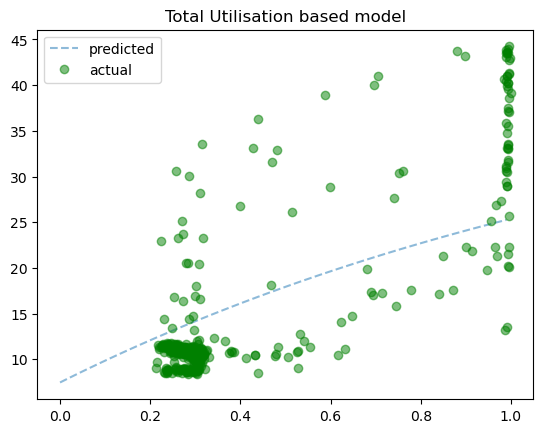

/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df['util'] = node_df['util'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_df['core'] = node_df['core'].diff()
/var/folders/42/cvcgsrbd5fgbmc436n0pvpxm0000gn/T/ipykernel_17357/3707206639.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


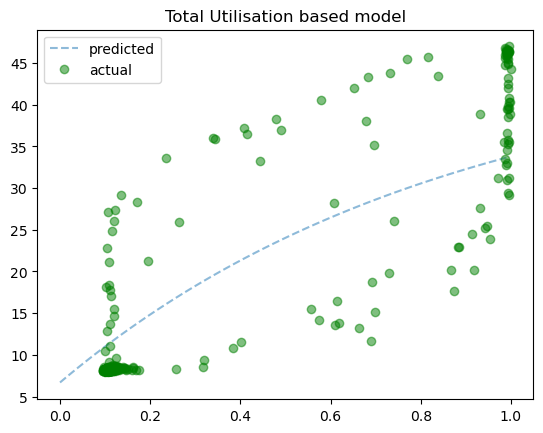

In [11]:
m = model.UtilisationPowerModel()
node_power_models = {}
for node in final['node'].unique():
#     if node != '10.242.64.5':
#         continue
    node_df = final[final['node'] == node]
    node_df['util'] = node_df['util'].diff()
    node_df['core'] = node_df['core'].diff()
    node_df['dram'] = node_df['dram'].diff()
    node_df['package'] = node_df['package'].diff()
    node_df['energy'] = node_df['core'] + node_df['dram'] + node_df['package']
    node_df.fillna(0, inplace=True)
    node_df['energy'] = node_df['energy'].shift(1)
    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util
    node_df['time_diff'] = node_df['time'].diff()
    node_df['power'] = node_df['energy']/node_df['time_diff']
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [12]:
node_power_models

{'10.242.64.4': (array([[13.897694 ],
         [14.042017 ],
         [13.904423 ],
         [16.728651 ],
         [13.657862 ],
         [13.799967 ],
         [14.1523   ],
         [14.536734 ],
         [13.995106 ],
         [13.255001 ],
         [13.217175 ],
         [13.593355 ],
         [13.422943 ],
         [13.981688 ],
         [13.634113 ],
         [13.627325 ],
         [13.048098 ],
         [13.5661545],
         [13.261875 ],
         [13.742529 ],
         [14.964886 ],
         [13.786463 ],
         [25.299383 ],
         [23.810867 ],
         [13.103409 ],
         [13.562754 ],
         [13.756054 ],
         [13.542332 ],
         [13.681593 ],
         [12.408333 ],
         [12.372992 ],
         [12.923279 ],
         [12.933701 ],
         [14.218943 ],
         [12.871124 ],
         [25.288977 ],
         [25.324337 ],
         [12.738602 ],
         [12.822367 ],
         [12.874603 ],
         [13.282484 ],
         [12.916332 ],
         [12.888521

In [13]:
node_df

,node,time,util,core,dram,package,energy,time_diff,power
12,10.242.64.5,1700556618,0.111590,0.0,0.0,0.0,248.931,NaN,13.651846
33,10.242.64.5,1700556648,0.098657,0.0,0.0,0.0,247.491,30.0,8.249700
53,10.242.64.5,1700556678,0.100315,0.0,0.0,0.0,244.476,30.0,8.149200
72,10.242.64.5,1700556708,0.116896,0.0,0.0,0.0,246.105,30.0,8.203500
93,10.242.64.5,1700556738,0.101310,0.0,0.0,0.0,245.835,30.0,8.194500
...,...,...,...,...,...,...,...,...,...
9913,10.242.64.5,1700571468,0.111424,0.0,0.0,0.0,247.932,30.0,8.264400
9932,10.242.64.5,1700571498,0.109766,0.0,0.0,0.0,249.963,30.0,8.332100
9952,10.242.64.5,1700571528,0.112253,0.0,0.0,0.0,250.539,30.0,8.351300
9972,10.242.64.5,1700571558,0.110761,0.0,0.0,0.0,251.934,30.0,8.397800


In [ ]:
n1 = final[final['node']=='10.242.64.5']

In [15]:
final[:30]

,node,time,util,core,dram,package
0,10.242.64.4,1700556600,4145861.05,2888800.506,155298.048,962933.502
1,10.242.64.5,1700556600,4254715.92,2752214.571,147958.821,917404.857
2,10.242.64.5,1700556603,4254722.74,2752214.571,147958.821,917404.857
3,10.242.64.4,1700556603,4145861.05,2888800.506,155298.048,962933.502
4,10.242.64.4,1700556606,4145861.05,2888800.506,155298.048,962933.502
5,10.242.64.5,1700556606,4254722.74,2752214.571,147958.821,917404.857
6,10.242.64.4,1700556609,4145861.05,2889028.746,155310.318,963009.582
7,10.242.64.5,1700556609,4254722.74,2752214.571,147958.821,917404.857
8,10.242.64.4,1700556612,4145878.38,2889028.746,155310.318,963009.582
9,10.242.64.5,1700556612,4254722.74,2752214.571,147958.821,917404.857
